In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Libraries**

In [105]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import tensorflow_hub as hub
import numpy as np


In [107]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [108]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.8.2
Hub version:  0.12.0
Eager mode:  True
GPU is NOT AVAILABLE


**Dataset Preparation**

In [109]:
data_root='/content/drive/MyDrive/Wayangs/'

In [110]:
train_path = '/content/drive/MyDrive/Wayangs/train'
val_path = '/content/drive/MyDrive/Wayangs/val'
IMAGE_SHAPE = (224, 224)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rescale = 1/255)

valid_generator = valid_datagen.flow_from_directory(
    directory=val_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    shear_range=0.2,
    rotation_range=30,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    class_mode = 'categorical',  
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 54 images belonging to 6 classes.
Found 179 images belonging to 6 classes.


In [111]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)
['Wayang Beber' 'Wayang Gedog' 'Wayang Golek' 'Wayang Krucil'
 'Wayang Kulit' 'Wayang Suluh']


**Model Training**

In [112]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_13 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 flatten_13 (Flatten)        (None, 1280)              0         
                                                                 
 dense_26 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 3,575,878
Trainable params: 1,317,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [113]:
model.compile(
  optimizer=RMSprop(learning_rate=0.0001),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [114]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=25,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

Epoch 1/25
6/6 [==============================] - 17s 2s/step - loss: 1.6911 - acc: 0.3073 - val_loss: 1.2261 - val_acc: 0.5556
Epoch 2/25
6/6 [==============================] - 12s 2s/step - loss: 1.1699 - acc: 0.5698 - val_loss: 1.0111 - val_acc: 0.7222
Epoch 3/25
6/6 [==============================] - 12s 2s/step - loss: 0.8930 - acc: 0.7318 - val_loss: 0.9004 - val_acc: 0.7407
Epoch 4/25
6/6 [==============================] - 12s 2s/step - loss: 0.7634 - acc: 0.7765 - val_loss: 0.8282 - val_acc: 0.7222
Epoch 5/25
6/6 [==============================] - 12s 2s/step - loss: 0.6922 - acc: 0.7654 - val_loss: 0.7254 - val_acc: 0.8148
Epoch 6/25
6/6 [==============================] - 13s 2s/step - loss: 0.5845 - acc: 0.8380 - val_loss: 0.6829 - val_acc: 0.8519
Epoch 7/25
6/6 [==============================] - 12s 2s/step - loss: 0.5358 - acc: 0.8324 - val_loss: 0.6706 - val_acc: 0.8333
Epoch 8/25
6/6 [==============================] - 12s 2s/step - loss: 0.4945 - acc: 0.8436 - val_loss: 0

In [115]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 2s 642ms/step - loss: 0.4212 - acc: 0.8889
Final loss: 0.42
Final accuracy: 88.89%


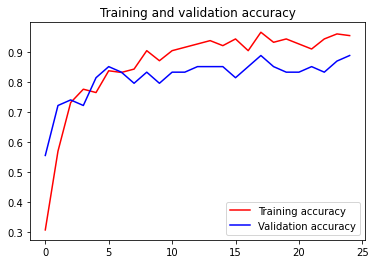

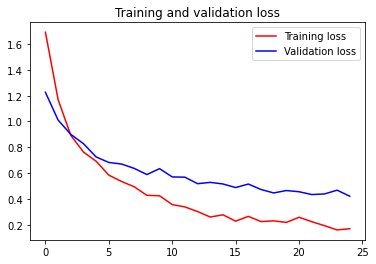

In [116]:
#----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = hist.history['acc']
val_acc  = hist.history['val_acc']
loss     = hist.history['loss']
val_loss = hist.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot  ( epochs, val_acc, 'b', label='Validation accuracy')
plt.title ('Training and validation accuracy')
# plt.title('Training accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and validation loss')
# plt.title('Training loss')
plt.legend()

plt.show()

**Saving Model**

In [ ]:
WAY_SAVED_MODEL = "saved_models/wayang"
tf.keras.models.save_model(model, WAY_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/wayang/assets


INFO:tensorflow:Assets written to: saved_models/wayang/assets


**Converting Model to TFlite**

In [ ]:
way_model = tf.keras.models.load_model(WAY_SAVED_MODEL,custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WAY_SAVED_MODEL)
tflite_model = converter.convert()

open("model_wayang.tflite", "wb").write(tflite_model)

14135072

In [ ]:
from shutil import copyfile

In [ ]:
saved_model_path = "/content/model_wayang.tflite"
gdrive_saved_model_path = '/content/drive/MyDrive/Wayang Capstone/ModelTFlite'
copyfile(saved_model_path, gdrive_saved_model_path)

'/content/drive/MyDrive/Wayang Capstone/ModelTFlite'